In [1]:
import plot
from shap.maskers import Independent
from sklearn.utils import resample
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [2]:
with open('dataset.pickle', 'rb') as f:
    X, y, display_data = pickle.load(f)
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('dataset.soa.explain.pickle', 'rb') as f:
    background_data, X_explain, display_data_explain = pickle.load(f)

In [3]:
try:
    with open(f'shapvalues.soa.log_odds.pickle', 'rb') as f:
        shap_log_odds_a, shap_log_odds_b, shap_log_odds_a_vs_b, is_finite, is_outlier, is_normal, feature_order = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

Loaded cached shap values


In [4]:
feature_names = np.array(X.columns)
n_features = len(feature_names)
n_samples = X.shape[0]

Now we define the functions to be explained:

In [5]:
predict_log_odds_a = lambda X: clf_a.predict_log_proba(X)[:, 1] - clf_a.predict_log_proba(X)[:, 0]
predict_log_odds_b = lambda X: clf_b.predict_log_proba(X)[:, 1] - clf_b.predict_log_proba(X)[:, 0]

And now we calculate SHAP values for each function:

In [6]:
def explain(predict, background_data):
    masker = Independent(data=background_data)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X_explain)
    shap_values.display_data = display_data_explain
    return shap_values

In [7]:
%%time
shap_log_odds_a = explain(predict_log_odds_a, background_data)
shap_log_odds_b = explain(predict_log_odds_b, background_data)

shap_log_odds_a_vs_b = shap_log_odds_b - shap_log_odds_a
shap_log_odds_a_vs_b.data = shap_log_odds_a.data
shap_log_odds_a_vs_b.display_data = shap_log_odds_a.display_data

is_finite = np.all(np.isfinite(shap_log_odds_a.values), axis=1) & np.all(np.isfinite(shap_log_odds_b.values), axis=1)
is_outlier = np.any(shap_log_odds_a.abs.values > 12, axis=1) | np.any(shap_log_odds_b.abs.values > 12, axis=1)
is_normal = is_finite & ~is_outlier
feature_order = np.flip(shap_log_odds_a_vs_b[is_normal].abs.mean(axis=0).values.argsort())

with open(f'shapvalues.soa.log_odds.pickle', 'wb') as f:
    pickle.dump((shap_log_odds_a, shap_log_odds_b, shap_log_odds_a_vs_b, is_finite, is_outlier, is_normal, feature_order), f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 376it [00:27, 11.14it/s]                         
Permutation explainer: 376it [00:22,  7.90it/s]                         


CPU times: user 1min 8s, sys: 5.94 s, total: 1min 14s
Wall time: 49.7 s


## Analyze

### Feature Importance

We estimate it with the mean absolute SHAP value (which is the default for this plot) and will also sort features subsequently in this order

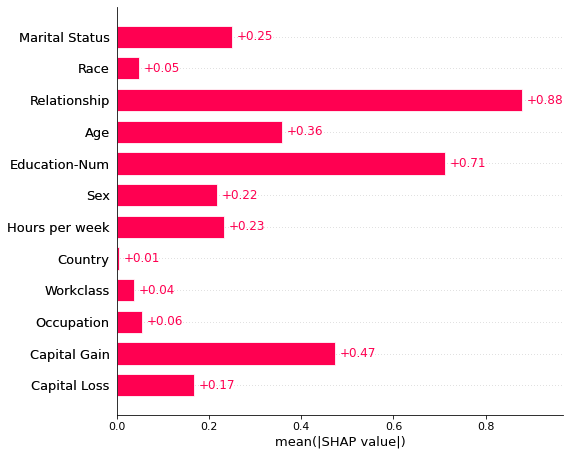

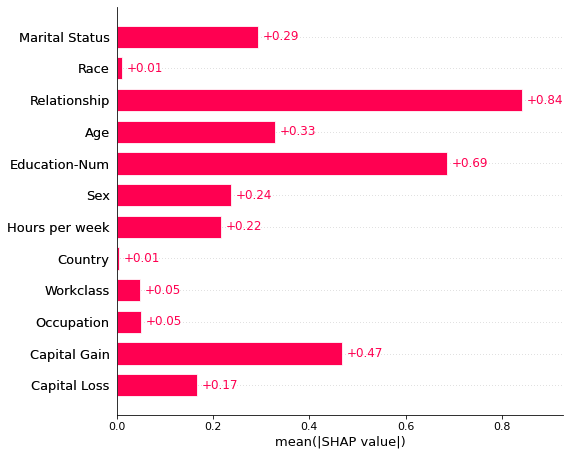

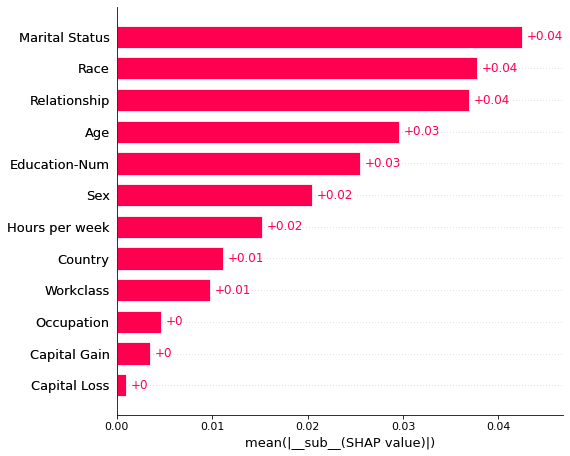

In [5]:
shap.plots.bar(shap_log_odds_a[is_normal], order=feature_order, max_display=n_features)
shap.plots.bar(shap_log_odds_b[is_normal], order=feature_order, max_display=n_features)
shap.plots.bar(shap_log_odds_a_vs_b[is_normal], order=feature_order, max_display=n_features)

### SHAP Value Distribution

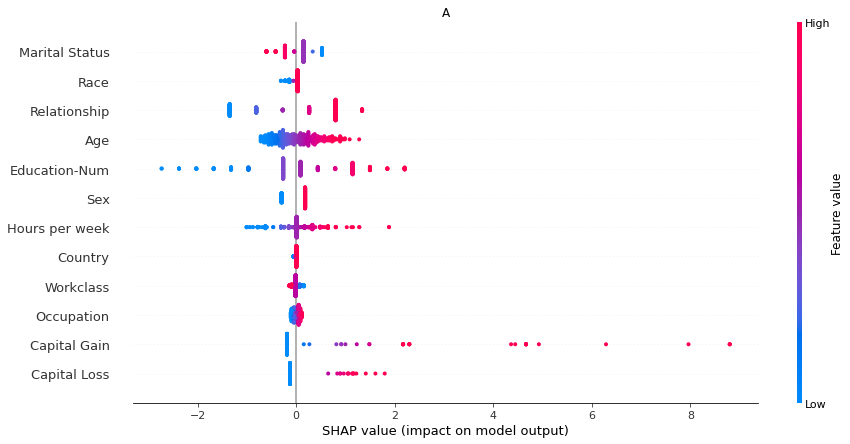

In [6]:
plot.shap_beeswarm(shap_log_odds_a[is_normal], 'A', order=feature_order, max_display=n_features)

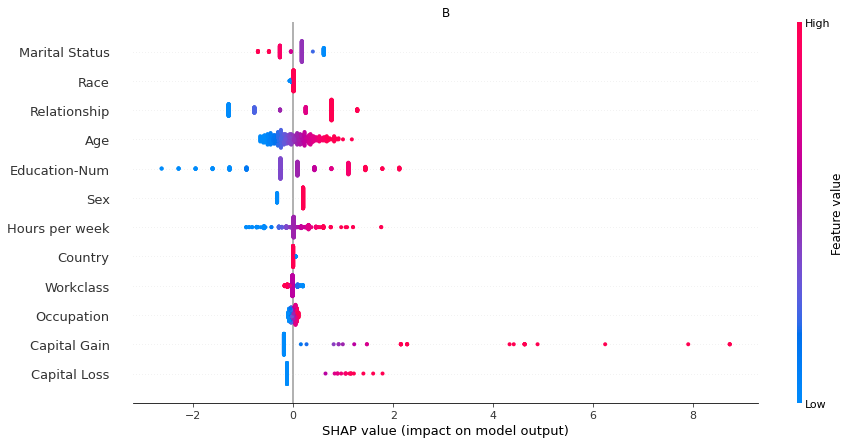

In [7]:
plot.shap_beeswarm(shap_log_odds_b[is_normal], 'B', order=feature_order, max_display=n_features)

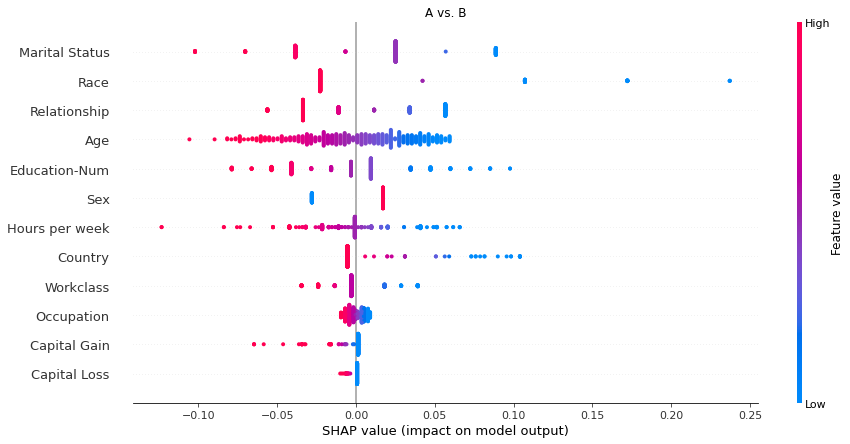

In [8]:
plot.shap_beeswarm(shap_log_odds_a_vs_b[is_normal], 'A vs. B', order=feature_order, max_display=n_features)

### Features' Partial Dependence Plots

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


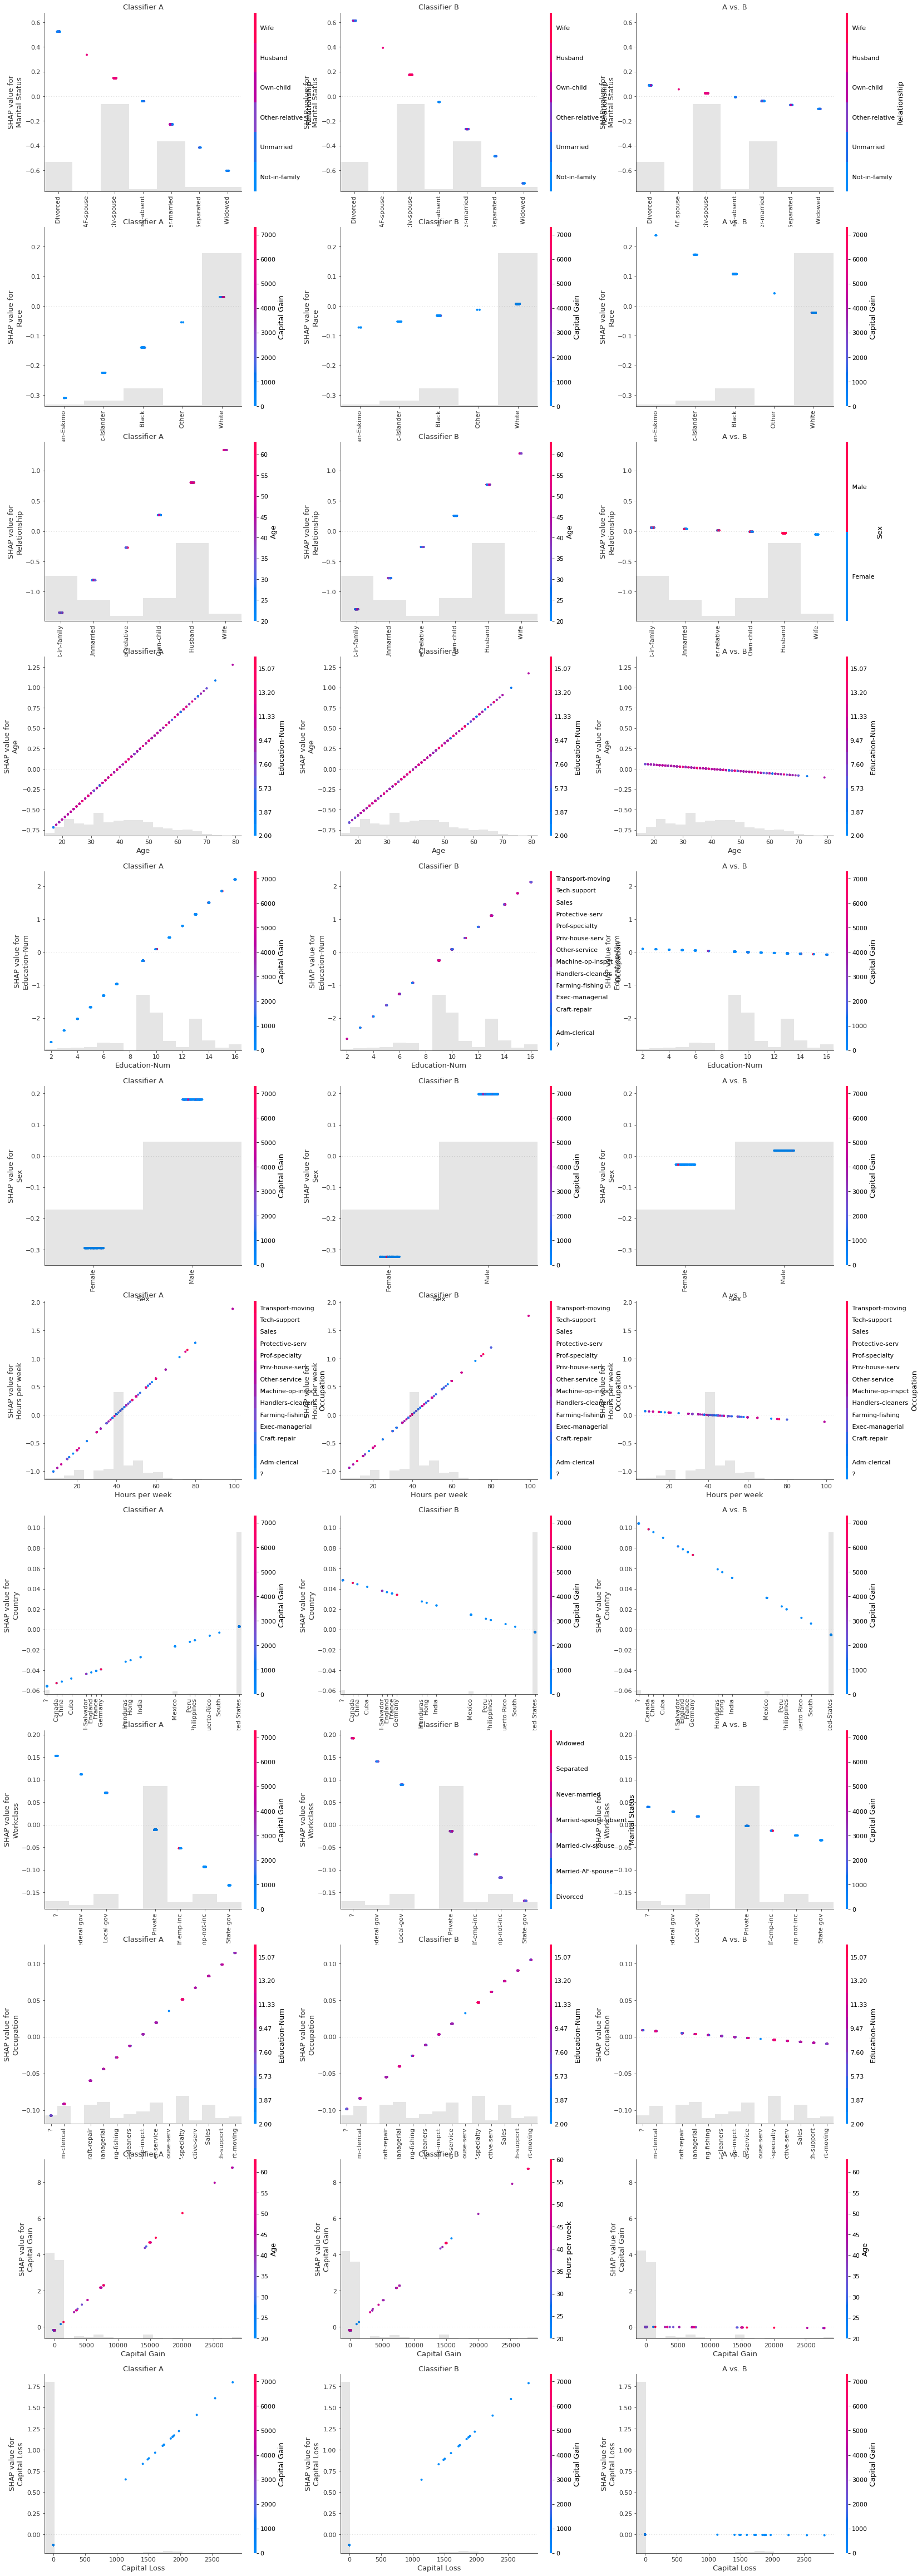

In [9]:
n_columns = 3
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names[feature_order]:
    ax = fig.add_subplot(n_rows, n_columns, i)
    plot.shap_scatter(shap_log_odds_a[is_normal], feature, 'Classifier A', ax=ax)
    plot.shap_scatter(shap_log_odds_b[is_normal], feature, 'Classifier B', ax=fig.add_subplot(n_rows, n_columns, i+1, sharey=ax))
    plot.shap_scatter(shap_log_odds_a_vs_b[is_normal], feature, 'A vs. B', ax=fig.add_subplot(n_rows, n_columns, i+2, sharey=ax))
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [10]:
order = plot.shap_force(shap_log_odds_a[is_normal], 'A')
plot.shap_force(shap_log_odds_b[is_normal], 'B', ordering=order)
plot.shap_force(shap_log_odds_a_vs_b[is_normal], 'A vs. B', ordering=order);

### Hierarchically Clustered SHAP Values

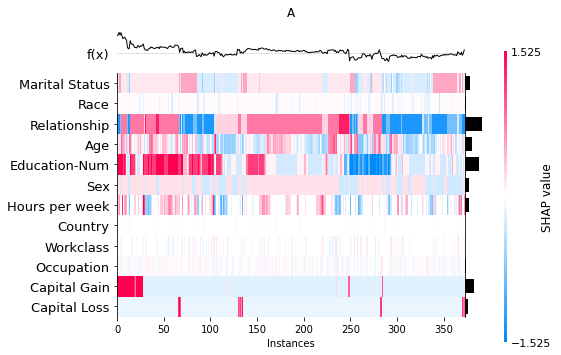

In [11]:
plot.shap_heatmap(shap_log_odds_a[is_normal], 'A', feature_order)

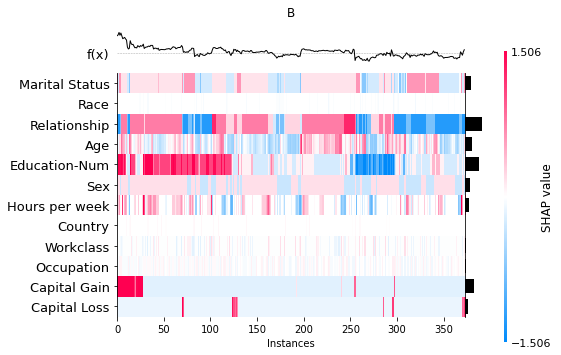

In [12]:
plot.shap_heatmap(shap_log_odds_b[is_normal], 'B', feature_order)

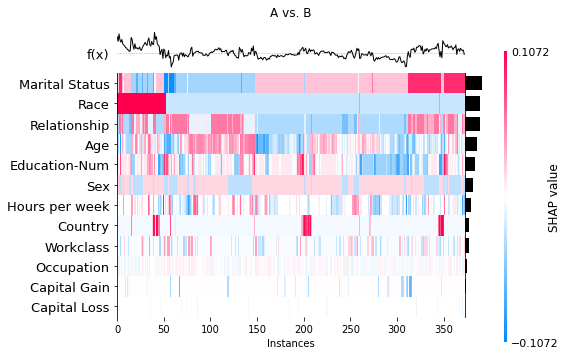

In [13]:
plot.shap_heatmap(shap_log_odds_a_vs_b[is_normal], 'A vs. B', feature_order)

### Unusual instances

#### Outliers in SHAP-values

An unusually high capital gain leads to a very big SHAP value for the instance's feature.

In [17]:
idx_outliers = np.where(is_outlier & is_finite)[0]

In [18]:
pd.DataFrame(display_data_explain[idx_outliers, :], index=idx_outliers, columns=feature_names)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
132,37.0,Self-emp-not-inc,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,50.0,United-States
183,38.0,Self-emp-not-inc,14.0,Married-civ-spouse,Prof-specialty,Husband,Black,Male,99999.0,0.0,60.0,United-States


In [19]:
for idx in idx_outliers:
    plot.shap_force(shap_log_odds_a[idx], f'Instance #{idx}')

In [20]:
for idx in idx_outliers:
    plot.shap_force(shap_log_odds_b[idx], f'Instance #{idx}')

#### Non-finite SHAP-values

~The `NaN` shap values in Workclass and Relationship seem to be connected to the unusually high capital gain~

In [14]:
idx_nonfinite = np.where(~is_finite)[0]

In [15]:
pd.DataFrame(display_data_explain[idx_nonfinite, :], index=idx_nonfinite, columns=feature_names)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country


In [16]:
pd.DataFrame(shap_log_odds_a[idx_nonfinite].values, index=idx_nonfinite, columns=feature_names)

ValueError: Empty data passed with indices specified.

In [ ]:
pd.DataFrame(shap_log_odds_b[idx_nonfinite].values, index=idx_nonfinite, columns=feature_names)